In [1]:
# Import relevant packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import data_preprocessor


/Users/lilyli/miniconda3/envs/arm_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# load dataset
training_data = pd.read_csv('../data/UNSW_NB15_training-set.csv')
training_data.head() 

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


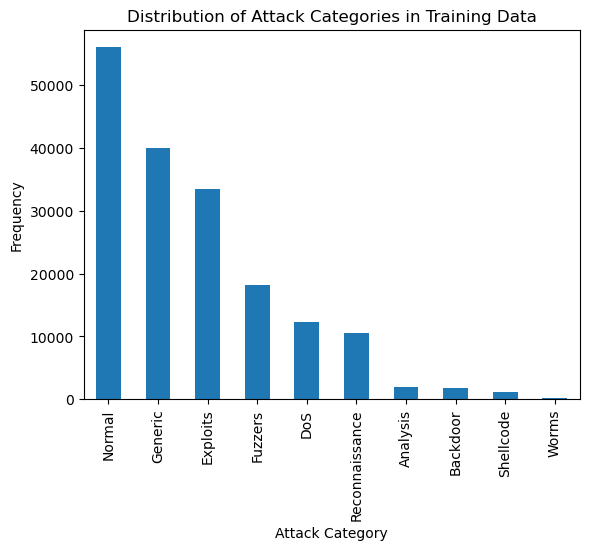

In [3]:
# Histogram of attack categories in training data
training_data['attack_cat'].value_counts().plot(kind='bar')
plt.title('Distribution of Attack Categories in Training Data')
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Preprocess the data
X_preprocessed, y, preprocessor = data_preprocessor.preprocess_data(training_data, label_col='attack_cat')

The shape of X is: (175341, 41)
The shape of y is: (175341,)


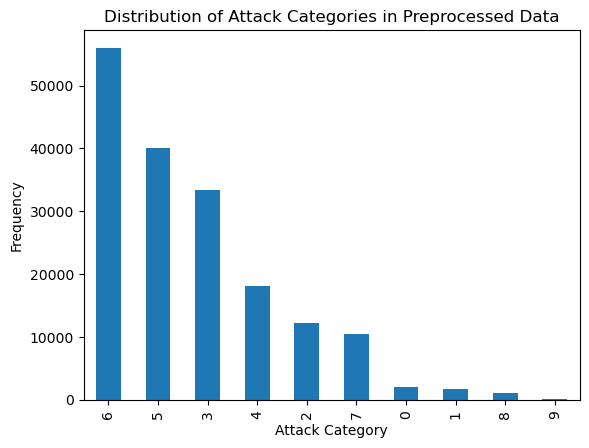

In [5]:
# Dimensions of the dataset
print ('The shape of X is: ' + str(X_preprocessed.shape))
print ('The shape of y is: ' + str(y.shape))

# Histogram of attacked categories in preprocessed data
y.value_counts().plot(kind='bar')
plt.title('Distribution of Attack Categories in Preprocessed Data')
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Define the model
tf.random.set_seed(1234)  # for consistent results

model = Sequential([
    tf.keras.Input(shape=(X_preprocessed.shape[1],)),  
    Dense(128, activation='relu', name="L1"),          
    Dense(64, activation='relu', name="L2"),
    Dense(32, activation='relu', name="L3"),
    Dense(10, activation='linear', name="L4")      
], name="my_model")

model.summary()

2025-09-14 14:07:00.550773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-09-14 14:07:00.550793: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-09-14 14:07:00.550798: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-09-14 14:07:00.550813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-14 14:07:00.550821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L4 (Dense)                      │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,042 (62.66 KB)

 Trainable params: 16,042 (62.66 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model using softmax cross-entropy loss and Adam optimizer
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']

)

history = model.fit(X_preprocessed, y,
                    epochs=50,       # Number of passes through the entire dataset
                    batch_size=32,   # Number of samples per gradient update
                    validation_split=0.1) # Use a portion of training data for validation

Epoch 1/50


2025-09-14 14:07:00.859828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4932/4932 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.4528 - loss: 1.8218 - val_accuracy: 0.8606 - val_loss: 0.4866
Epoch 2/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.4528 - loss: 1.8218 - val_accuracy: 0.8606 - val_loss: 0.4866
Epoch 2/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7371 - loss: 0.8531 - val_accuracy: 0.8724 - val_loss: 0.4169
Epoch 3/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7371 - loss: 0.8531 - val_accuracy: 0.8724 - val_loss: 0.4169
Epoch 3/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7596 - loss: 0.7108 - val_accuracy: 0.8747 - val_loss: 0.3904
Epoch 4/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7596 - loss: 0.7108 - val_accuracy: 0.8747 - val_loss: 0.3904
Epoch 4/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7653 - loss: 0.6669 - val_accuracy: 0.8754 - val_loss: 0.3779
Epoch 5/50
4932/4932 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7653 - loss: 0.6669 - val

In [9]:
# Get the category mapping from training
cat_type = training_data['attack_cat'].astype('category')
category_mapping = dict(zip(cat_type.cat.categories, range(len(cat_type.cat.categories))))

# Load test data
test_data = pd.read_csv('../data/UNSW_NB15_testing-set.csv')

# Map test labels using the training mapping
y_test = test_data['attack_cat'].map(category_mapping)

print('Category mapping (label -> integer):')
print(category_mapping)

Category mapping (label -> integer):
{'Analysis': 0, 'Backdoor': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [10]:
# Select only the numerical columns used in training
numerical_cols = X_preprocessed.columns
X_test = test_data[numerical_cols]

# Transform using the fitted preprocessor from training
X_test_preprocessed = preprocessor.transform(X_test)

# Prepare test labels
y_test = test_data['attack_cat'].map(category_mapping)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100}%')

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7066 - loss: 0.9090
Test Loss: 1.0048444271087646, Test Accuracy: 74.0404725074768%


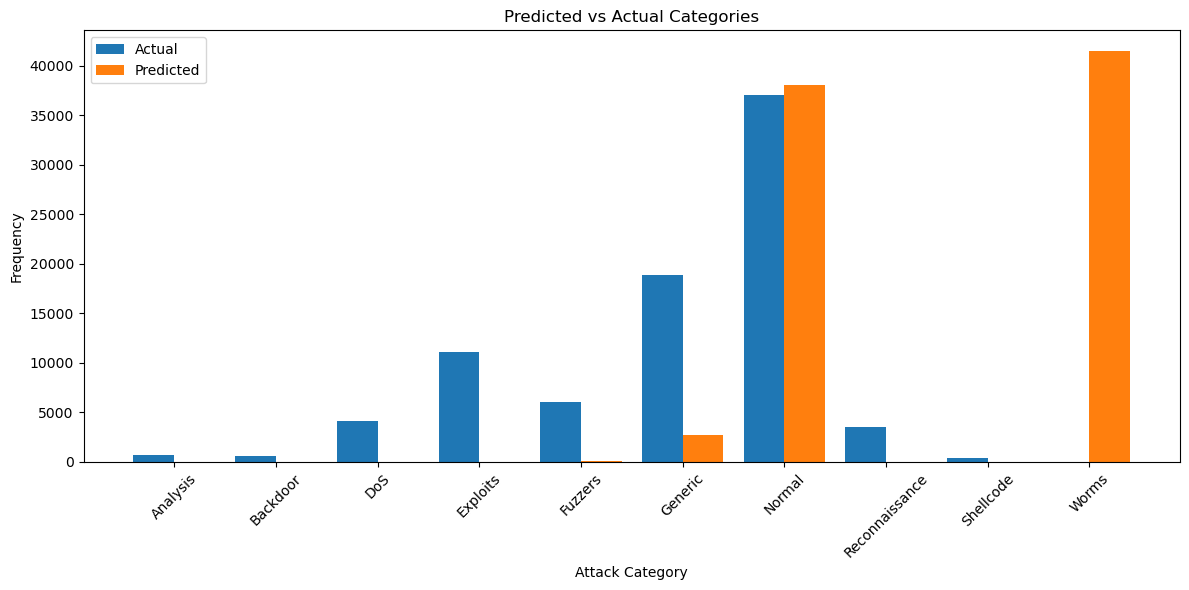

In [12]:
# Get counts for each category
actual_counts = pd.Series(actual_labels).value_counts().reindex(list(int_to_label.values()), fill_value=0)
predicted_counts = pd.Series(predicted_labels).value_counts().reindex(list(int_to_label.values()), fill_value=0)

categories = list(int_to_label.values())
x = np.arange(len(categories))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, actual_counts, width=0.4, label='Actual')
plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted')
plt.xticks(x, categories, rotation=45)
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.title('Predicted vs Actual Categories')
plt.legend()
plt.tight_layout()
plt.show()

